In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# カーネル関数k(x, x’)を定義
def GPk(xv, zv, sd = 1):
    # np.equal.outerを利用すると、0, 1(False, True)の全てのくみの行列が出力される
    # 外積といっても高校の数学で習っていたような外積（クロス積）を求めるのではなく、2つのベクトルの要素の全ての掛け合わせるテンソル積のことです。日本語の名称では同じ外積を使用することがありますが、英語では2つのベクトルに直交するようなベクトルをもとめる意味でcross product、今回扱う意味での全ての組み合わせの掛け合わせを求める意味でouterと呼びます。
    return (np.outer(xv, zv) + sd ** 2 * np.equal.outer(xv, zv))

In [3]:
n, sd = 30, 0.5 # 設定
# 単回帰を想定
theta = 1 # 回帰係数 

In [4]:
# データ生成
X = np.random.normal(scale = 3, size = n)
Yob = np.dot(X, theta) + np.random.normal(scale = sd, size = n)
newx = np.linspace(X.min(), X.max(), 100) # 予測点


In [5]:
# カーネル関数の計算
Kob = GPk(X, X, sd = sd)
kx = GPk(newx, X, sd = sd)
knewx = GPk(newx, newx, sd = sd)

In [6]:
# ガウス過程による回帰関数の予測
# 母集団yが従う分布を計算で求める
GPf = np.dot(kx, np.linalg.solve(Kob, Yob))
GPv = np.maximum(np.diag(knewx - np.dot(kx, np.linalg.solve(Kob, kx.T))), 0)

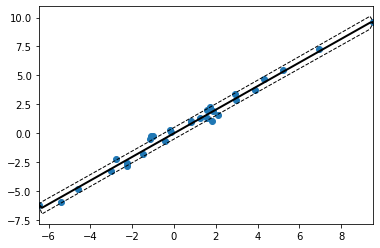

In [7]:
# プロット
plt.xlim(X.min(), X.max())
plt.scatter(X, Yob) # データ点
plt.plot(newx, GPf, 'k-', lw = 2) # 推定した回帰関数, 'k-'は実線

# 信頼区間
plt.plot(newx, GPf + np.sqrt(GPv), 'k--', lw = 1) # 'k--'は破線
plt.plot(newx, GPf - np.sqrt(GPv), 'k--', lw = 1) # 'k--'は破線
plt.show();

In [8]:
# ガウス過程モデルによる回帰分析
# トレーニングデータの生成
n, sd = 100, 1 # 設定
theta = 1 # 回帰係数
X = np.random.normal(scale = 3, size =n).reshape(n, -1)
Yob = np.dot(X, theta) + np.random.normal(scale = sd, size =n).reshape(n, -1)

In [9]:
# カーネル関数の定義: ガウスカーネル + ホワイトカーネル
kk = gp.kernels.RBF() + gp.kernels.WhiteKernel()
gpm = gp.GaussianProcessRegressor(kernel=kk)
gpm.fit(X, Yob) # データへのフィッティング

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [10]:
newx = np.linspace(-7, 7, 100).reshape(100, -1) # 予測点
# 予測値と分散共分散行列
GPf, GPv = gpm.predict(newx, return_cov=True)
GPsd = np.sqrt(np.diag(GPv)) # 予測値の標準偏差

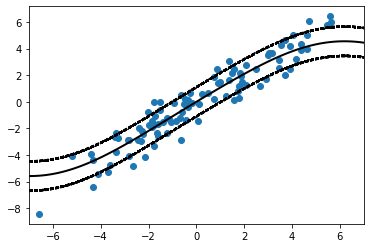

In [11]:
# プロット
plt.xlim(-7, 7)
plt.scatter(X, Yob)
plt.plot(newx, GPf, 'k-', lw = 2)
plt.plot(newx, GPf + GPsd, 'k--', lw = 1)
plt.plot(newx, GPf - GPsd, 'k--', lw = 1)
plt.show()

In [12]:
# ガウス過程モデルによる判別分析
from common import mlbench as ml

In [13]:
X, y = ml.spirals(200, cycles = 1.2, sd = 0.16) # データ生成

In [14]:
# カーネル関数の定義: ガウスカーネル + ホワイトカーネル
kk = gp.kernels.RBF() + gp.kernels.WhiteKernel()
gpm = gp.GaussianProcessClassifier(kernel=kk)
gpm.fit(X, y) # データフィッティング

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GaussianProcessClassifier(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [15]:
m = 100; newx = np.linspace(-1.2, 1.2, m) # 予測点生成
newdat = np.array([(y, x) for x in newx for y in newx])
# newdat.shape
GPpred = gpm.predict(newdat)

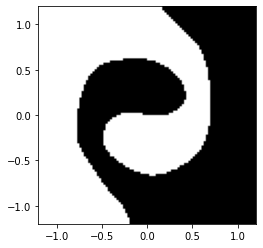

In [16]:
# プロット
ext = (-1.2, 1.2, -1.2, 1.2)
plt.imshow(GPpred.reshape(m, -1)[::-1], cmap='gray', extent = ext)
plt.show();

In [20]:
# ベイズ最適化
# ベイズ最適化によるモデル選択
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
# scikit-optimizeをpip installするとskoptが使える
from skopt import gp_minimize
from common import mlbench as ml

In [21]:
X, y = ml.spirals(200, cycles=1, sd = 0.1, label = [0, 1]) # データ生成

In [23]:
# 検証誤差を計算する関数を定義
# 目的関数を定義
def svmcv(par):
    # logC: 正則化パラメータCの対数スケール, logsig: カーネル幅の対数スケール
    logC, logsig = par
    sv = SVC(kernel='rbf', gamma=10 ** logsig, C = 10 ** logC)
    cv = cross_validate(sv, X, y, scoring='accuracy', cv = 5)
    return (1 - np.mean(cv['test_score']))

In [24]:
# カーネル幅の範囲をデータから決める
from scipy.spatial import distance # distanceの計算

In [25]:
cg = np.log10(1/np.percentile(distance.pdist(X), [1, 99]) ** 2)
space = [(-5., 5.), (cg[1], cg[0])]

In [26]:
x0 = [0., np.mean(cg)]
# acq_funcにLCBを設定すると、UCB: 上側信頼限界(なのに評価してるのは下側っていうね)
op = gp_minimize(svmcv, space, x0 = x0, acq_func='LCB', n_calls = 100)

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/sit

In [28]:
optC, optsig = 10 ** np.array(op.x)
optC, optsig

(100000.0, 90.41982223811307)

In [29]:
from skopt.plots import plot_convergence

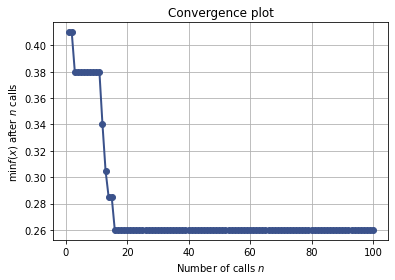

In [31]:
plot_convergence(op)
plt.show();

In [32]:
x0 = [0., np.mean(cg)]
# acq_funcにEIを設定すると、期待改善量
op = gp_minimize(svmcv, space, x0 = x0, acq_func='EI', n_calls = 100)

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [33]:
optC, optsig = 10 ** np.array(op.x)
optC, optsig

(100000.0, 90.41982223811307)

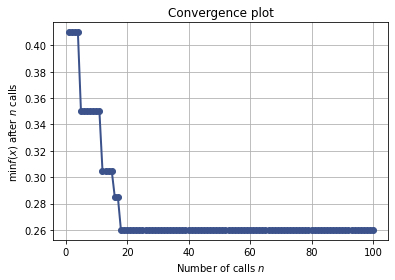

In [34]:
plot_convergence(op)
plt.show();